In [1]:
import numpy as np
import pandas as pd
import spacy

# Ingredient Cleaning

The goal here is to simplify the ingredients list from an entry like "1 pound trimmed boneless center pork loin, sinew removed cut into 1-inch chunks, well chilled" to "pork loin" for more efficient vectorizing.

### Read in Data

In [2]:
dirty = pd.read_csv('data/dirty_recipes.csv')
print(dirty.info())
dirty.head()

C:\Users\leejl\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1174268 entries, 0 to 1174267
Data columns (total 4 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   title        1174268 non-null  object
 1   method       1174267 non-null  object
 2   ingredients  1174268 non-null  object
 3   url          1029720 non-null  object
dtypes: object(4)
memory usage: 35.8+ MB
None


,title,method,ingredients,url
0,"Lentil, Apple, and Turkey Wrap","1. Place the stock, lentils, celery, carrot, t...",['4 cups low-sodium vegetable or chicken stock...,NaN
1,Boudin Blanc Terrine with Red Onion Confit,Combine first 9 ingredients in heavy medium sa...,"['1 1/2 cups whipping cream', '2 medium onions...",NaN
2,Potato and Fennel Soup Hodge,In a large heavy saucepan cook diced fennel an...,"['1 fennel bulb (sometimes called anise), stal...",NaN
3,Mahi-Mahi in Tomato Olive Sauce,Heat oil in heavy large skillet over medium-hi...,"['2 tablespoons extra-virgin olive oil', '1 cu...",NaN
4,Spinach Noodle Casserole,Preheat oven to 350°F. Lightly grease 8x8x2-in...,"['1 12-ounce package frozen spinach soufflé, t...",NaN


### Drop Duplicates

In [3]:
dirty.drop_duplicates(['title', 'method'], inplace=True)

# there seems to be a single recipe without a method
# reset dataframe without it

dirty = dirty.loc[dirty['method'].notnull(), :]
dirty.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1153057 entries, 0 to 1174267
Data columns (total 4 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   title        1153057 non-null  object
 1   method       1153057 non-null  object
 2   ingredients  1153057 non-null  object
 3   url          1011613 non-null  object
dtypes: object(4)
memory usage: 44.0+ MB


### Format Ingredients

In [4]:
def ingr_str_to_list(ingr_str):
    '''
    converts the ingredients column
    each entry => list of ingredients, one string per ingredient
    removes "ADVERTISEMENT"
    use with .apply()
    '''
    ingr_list = ingr_str[2:-2].split(r"', '")
    return [i.lower().replace('advertisement', '') for i in ingr_list]

# apply it
dirty['ingredients'] = dirty['ingredients'].apply(ingr_str_to_list)

# check an entry
dirty['ingredients'][250_000]

['2 tablespoons olive oil',
 '3 tablespoons finely minced garlic',
 '4 eggs',
 '1 cup finely chopped scallions',
 '1/2 cup finely chopped fresh coriander',
 '1 1/2 pounds lean, boneless pork, cut into five equal-size portions',
 '1/2 pound medium egg noodles',
 '1/4 cup peanut, vegetable or corn oil',
 '1 cup finely minced heart of celery',
 '1 pound shrimp, shelled and deveined, about 2 cups',
 '3 or 4 fresh, hot, red or green chili peppers',
 '2 cups rich chicken stock (see recipe)',
 '3/4 pound bean sprouts']

### Save to CSV

Output a CSV file in order to present recommendations without NLP modifications later.

In [5]:
#dirty.to_csv('data/recipes_for_output.csv', index=False)

### Isolating Base Ingredients

In [6]:
# load robust spaCy model
nlp = spacy.load('en_core_web_lg')

# rejoin ingredients
dirty['ingredients'] = dirty['ingredients'].apply('. '.join)

In [7]:
# remove digits
def alpha_converter(ingr_str):
    '''
    removes digits
    use with .apply()
    '''
    return ''.join(x for x in ingr_str if not x.isdigit() or x == ' ')

# apply it
dirty['ingredients'] = dirty['ingredients'].apply(alpha_converter)

In [8]:
# remove standard units of measurement
def unit_remover(ingr_str):
    '''
    removes units of measure
    use with .apply()
    '''
    measures = ['ounce', 'ounces', 'cups', 'cup', 'teaspoon', 'tablespoon', 'tablespoons', 'teaspoons', 
                'c', 'quarts', 'quart', 'g', 'tbsp', 'tbsps', 'ml', 'lb', 'lbs', 'pound', 'pounds', 'tbs', 
                'oz', 'pkg', 'package', 'tsp', 'grams', 'can', 'l', 'liter', 'liters', 'gallon', 'gallons']
    ingr_list = ingr_str.split()
    return ' '.join((tok for tok in ingr_list if tok not in measures))

# apply it
dirty['ingredients'] = dirty['ingredients'].apply(unit_remover)

In [9]:
# special cases
herbs = set(['thyme', 'rosemary', 'tarragon', 'basil', 'marjoram', 'oregano', 'cilantro', 'mint', 'parsley'])
hearts = set(['palm', 'celery', 'romaine'])

In [10]:
def ingredient_isolator(ingr_str):
    '''
    not lightweight -- time intensive
    pulls out base ingredient from a string of ingredients
    requires spaCy
    '''
    doc = nlp(ingr_str)
    root_str = ''
    
    for tok in doc:

        # check for garlic cloves special case
        # garlic cloves => garlic OR cloves of garlic => garlic
        if tok.text == 'clove' or tok.text == 'cloves':
            if 'garlic' in [str(i) for i in tok.subtree]:
                root_str += ' ' + 'garlic'
                continue
        
            
        # check for herb sprigs special case
        # herb sprigs => herb OR sprigs of herb => herb
        
        if tok.text == 'sprig' or tok.text == 'sprigs':
            root_str += ' ' + ''.join(herbs & set(str(child) for child in tok.subtree))
            continue

        # check for hearts special case
        # veggie hearts => veggie OR hearts of veggie => veggie
        if tok.text == 'heart' or tok.text == 'hearts':
            if any(heart in hearts for heart in (str(child) for child in tok.subtree)):
                root_str += ' ' + ''.join(hearts & set(str(child) for child in tok.subtree))
                continue

        # main use case
        if tok.pos_ == 'NOUN' and (tok.dep_ == 'ROOT' or tok.dep_ == 'dobj' or tok.dep_ == 'appos'):  
            root_str += ' ' + tok.text

    return root_str.strip()

In [14]:
%%time
#dirty['ingredients'] = dirty['ingredients'].apply(ingredient_isolator)

Wall time: 4h 32min 3s


In [15]:
dirty.head()

,title,method,ingredients,url
0,"Lentil, Apple, and Turkey Wrap","1. Place the stock, lentils, celery, carrot, t...",vegetable lentils lentils celery carrot thyme...,NaN
1,Boudin Blanc Terrine with Red Onion Confit,Combine first 9 ingredients in heavy medium sa...,cream onions salt leaves cloves garlic pepper ...,NaN
2,Potato and Fennel Soup Hodge,In a large heavy saucepan cook diced fennel an...,onion butter potatoes broth milk,NaN
3,Mahi-Mahi in Tomato Olive Sauce,Heat oil in heavy large skillet over medium-hi...,oil onion wine paste tomatoes fillets olives p...,NaN
4,Spinach Noodle Casserole,Preheat oven to 350°F. Lightly grease 8x8x2-in...,noodles cream sauce nutmeg cheese,NaN


In [16]:
# quickly! to CSV!
#dirty.to_csv('data/ingr_tok.csv', index=False)

### Final Dataset Construction

In [2]:
# to fix a mistake -- should have made a new column for the tokenized ingredients

# read back in recipes_for_output
dirty = pd.read_csv('data/recipes_for_output.csv')
dirty.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1153057 entries, 0 to 1153056
Data columns (total 4 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   title        1153057 non-null  object
 1   method       1153057 non-null  object
 2   ingredients  1153057 non-null  object
 3   url          1011613 non-null  object
dtypes: object(4)
memory usage: 35.2+ MB


In [3]:
ingr_tok = pd.read_csv('data/ingr_tok.csv')
ingr_tok.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1153057 entries, 0 to 1153056
Data columns (total 4 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   title        1153057 non-null  object
 1   method       1153057 non-null  object
 2   ingredients  1150037 non-null  object
 3   url          1011613 non-null  object
dtypes: object(4)
memory usage: 35.2+ MB


In [4]:
ingr_tok.rename(columns={'ingredients': 'ingredient_tokens'}, inplace=True)

In [5]:
big_dumb = pd.merge(dirty, ingr_tok[['ingredient_tokens']], how='inner', left_index=True, right_index=True)
big_dumb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1153057 entries, 0 to 1153056
Data columns (total 5 columns):
 #   Column             Non-Null Count    Dtype 
---  ------             --------------    ----- 
 0   title              1153057 non-null  object
 1   method             1153057 non-null  object
 2   ingredients        1153057 non-null  object
 3   url                1011613 non-null  object
 4   ingredient_tokens  1150037 non-null  object
dtypes: object(5)
memory usage: 44.0+ MB


In [6]:
# check out unique ingredients

bd_ingr_set = set((' '.join(str(x) for x in big_dumb['ingredient_tokens'].values)).split())
len(bd_ingr_set)

10519

In [7]:
# check for some rare-ish things

print('asafoetida' in bd_ingr_set)
print('sole' in bd_ingr_set)
print('verbena' in bd_ingr_set)
print('gooseberries' in bd_ingr_set)
print('treacle' in bd_ingr_set)
print('guajillo' in bd_ingr_set)
print('kamut' in bd_ingr_set)
print('epazote' in bd_ingr_set)
print('cuttlefish' in bd_ingr_set)

True
True
True
True
True
True
True
True
True


### Drop Nulls Generated During Ingredient Isolation

In [7]:
big_dumb.isnull().sum()

title                     0
method                    0
ingredients               0
url                  141444
ingredient_tokens      3020
dtype: int64

In [8]:
big_dumb.dropna(subset=['ingredient_tokens'], inplace=True)
big_dumb.isnull().sum()

title                     0
method                    0
ingredients               0
url                  139785
ingredient_tokens         0
dtype: int64

In [9]:
print(big_dumb.info())
big_dumb.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1150037 entries, 0 to 1153056
Data columns (total 5 columns):
 #   Column             Non-Null Count    Dtype 
---  ------             --------------    ----- 
 0   title              1150037 non-null  object
 1   method             1150037 non-null  object
 2   ingredients        1150037 non-null  object
 3   url                1010252 non-null  object
 4   ingredient_tokens  1150037 non-null  object
dtypes: object(5)
memory usage: 92.6+ MB
None


,title,method,ingredients,url,ingredient_tokens
0,"Lentil, Apple, and Turkey Wrap","1. Place the stock, lentils, celery, carrot, t...",['4 cups low-sodium vegetable or chicken stock...,NaN,vegetable lentils lentils celery carrot thyme...
1,Boudin Blanc Terrine with Red Onion Confit,Combine first 9 ingredients in heavy medium sa...,"['1 1/2 cups whipping cream', '2 medium onions...",NaN,cream onions salt leaves cloves garlic pepper ...
2,Potato and Fennel Soup Hodge,In a large heavy saucepan cook diced fennel an...,"['1 fennel bulb (sometimes called anise), stal...",NaN,onion butter potatoes broth milk
3,Mahi-Mahi in Tomato Olive Sauce,Heat oil in heavy large skillet over medium-hi...,"['2 tablespoons extra-virgin olive oil', '1 cu...",NaN,oil onion wine paste tomatoes fillets olives p...
4,Spinach Noodle Casserole,Preheat oven to 350°F. Lightly grease 8x8x2-in...,"['1 12-ounce package frozen spinach soufflé, t...",NaN,noodles cream sauce nutmeg cheese


### Final Output to CSV for Recommender

In [10]:
big_dumb.to_csv('data/compressed_clean.csv', index=False, compression='gzip')

### playing around with the ingredients

In [9]:
bd_list = ' '.join(str(x) for x in big_dumb['ingredient_tokens'].values).split()

In [13]:
bd_list = pd.Series(bd_list)

In [21]:
counts = bd_list.value_counts()

In [24]:
counts[:100].index

Index(['salt', 'sugar', 'oil', 'pepper', 'butter', 'flour', 'garlic', 'onion',
       'cheese', 'water', 'powder', 'juice', 'milk', 'cream', 'sauce', 'eggs',
       'vinegar', 'tbsp', 'tomatoes', 'extract', 'onions', 'parsley', 'leaves',
       'cinnamon', 'soda', 'egg', 'mustard', 'broth', 'beans', 'potatoes',
       'ginger', 'baking', 'mix', 'vanilla', 'seeds', 'wine', 'ounces',
       'ounce', 'thyme', 'tsp', 'slices', 'chips', 'mushrooms', 'cumin',
       'oregano', 'paprika', 'flakes', 'carrots', 'syrup', 'mayonnaise',
       'stock', 'cilantro', 'beef', 'celery', 'basil', 'seasoning', 'honey',
       'paste', 'zest', 'bread', 'chocolate', 'almonds', 'peppers', 'rice',
       'lemon', 'nutmeg', 'breasts', 'walnuts', 'cans', 'raisins', 'pecans',
       'yeast', 'cloves', 'corn', 'olives', 'crumbs', 'leaf', 'buttermilk',
       'spinach', 'yogurt', 'rosemary', 'bacon', 'chicken', 'sausage',
       'chives', 'yolks', 'cornstarch', 'whites', 'shrimp', 'noodles', 'peas',
       'spray

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

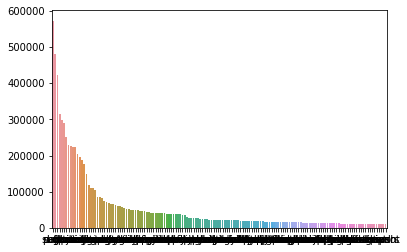

In [28]:
sns.barplot(x=counts[:150].index, y=counts[:150].values)

In [30]:
counts.head(150)

salt      573262
sugar     480528
oil       423555
pepper    315100
butter    297120
           ...  
cup        10195
squash     10042
rind       10036
capers      9855
carrot      9837
Length: 150, dtype: int64